In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [8]:
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime

In [29]:
elec_all_data = pd.read_csv("C:\\Users\\anura\\Downloads\\electricity.csv\\electricity.csv", index_col='timestamp', parse_dates=True)

In [17]:
elec_all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 555 entries, Panther_office_Clementine to Cockatoo_health_Ashlie
dtypes: float64(555)
memory usage: 74.4 MB


In [30]:
buildingname = 'Panther_office_Hannah'

In [31]:
office_example_prediction_data = pd.DataFrame(elec_all_data[buildingname].truncate(before='2017-01-01')).fillna(method='ffill')

In [32]:
office_example_prediction_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Panther_office_Hannah  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


<Axes: xlabel='timestamp'>

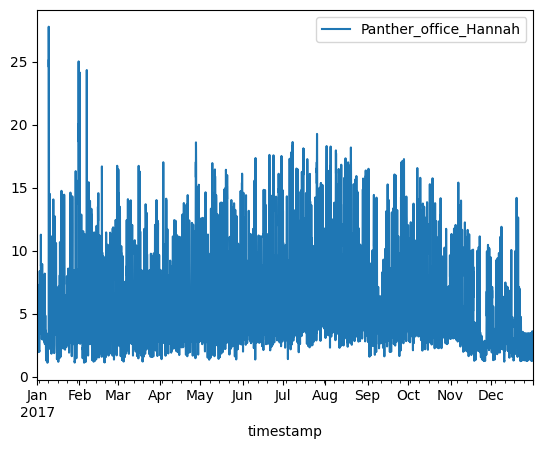

In [33]:
office_example_prediction_data.plot()

In [36]:
weather_data = pd.read_csv("C:\\Users\\anura\\Downloads\\weather.csv\\weather.csv", index_col='timestamp', parse_dates=True)

In [37]:
weather_data_site = weather_data[weather_data.site_id == 'Panther'].truncate(before='2017-01-01')

In [35]:
print(weather_data.columns)


Index(['site_id', 'airTemperature', 'cloudCoverage', 'dewTemperature',
       'precipDepth1HR', 'precipDepth6HR', 'seaLvlPressure', 'windDirection',
       'windSpeed'],
      dtype='object')


In [40]:
# Step 1: Select only numeric columns
weather_numeric = weather_data_site.select_dtypes(include='number')

# Step 2: Resample to hourly frequency and calculate mean
weather_hourly = weather_numeric.resample("H").mean()

# Step 3: Remove outliers (e.g., values less than -40)
weather_hourly_nooutlier = weather_hourly[weather_hourly > -40]

# Step 4: Fill missing values using forward fill
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')

In [41]:
temperature = weather_hourly_nooutlier_nogaps["airTemperature"]

<Axes: xlabel='timestamp'>

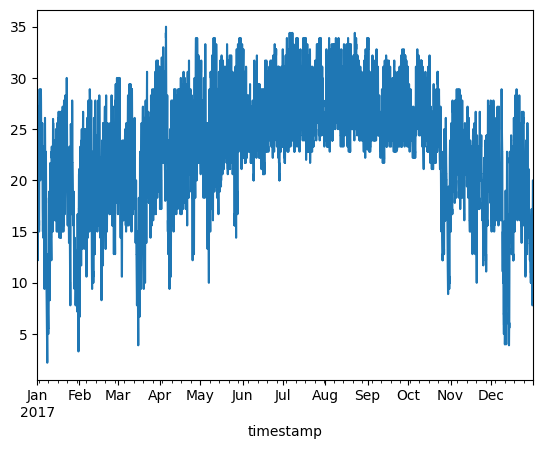

In [42]:
temperature.plot()

In [43]:
training_months = [4,5,6]
test_months = [7]

In [44]:
trainingdata = office_example_prediction_data[office_example_prediction_data.index.month.isin(training_months)]
testdata = office_example_prediction_data[office_example_prediction_data.index.month.isin(test_months)]

In [45]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2184 entries, 2017-04-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Panther_office_Hannah  2184 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


In [46]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2017-07-01 00:00:00 to 2017-07-31 23:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Panther_office_Hannah  744 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


In [47]:
train_features = pd.concat([pd.get_dummies(trainingdata.index.hour), 
                                     pd.get_dummies(trainingdata.index.dayofweek), 
                                     pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)], axis=1).dropna()

In [48]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,0,1,2,3,4,5,6,0
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,21.7
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,21.0
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,18.9
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,20.6
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,21.0


In [49]:
model = KNeighborsRegressor().fit(np.array(train_features), np.array(trainingdata.values));

In [50]:
test_features = np.array(pd.concat([pd.get_dummies(testdata.index.hour),
                                    pd.get_dummies(testdata.index.dayofweek),
                                    pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)], axis=1).dropna())

In [53]:
predictions = model.predict(test_features)

In [54]:
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(predictions, index=testdata.index)], axis=1)

In [55]:
predicted_vs_actual.columns = ["Actual", "Predicted"]

In [56]:
predicted_vs_actual.head()

,Actual,Predicted
timestamp,,
2017-07-01 00:00:00,5.3370,5.49464
2017-07-01 01:00:00,3.8547,5.03418
2017-07-01 02:00:00,5.5751,4.18462
2017-07-01 03:00:00,4.1248,4.01956
2017-07-01 04:00:00,3.3497,5.26522


<Axes: xlabel='timestamp'>

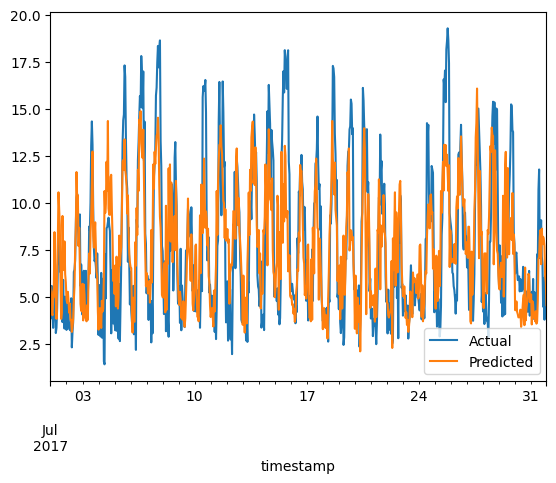

In [57]:
predicted_vs_actual.plot()

In [58]:
trainingdata.columns = ["Actual"]


In [59]:
predicted_vs_actual_plus_training = pd.concat([trainingdata, predicted_vs_actual], sort=True)

<Axes: xlabel='timestamp'>

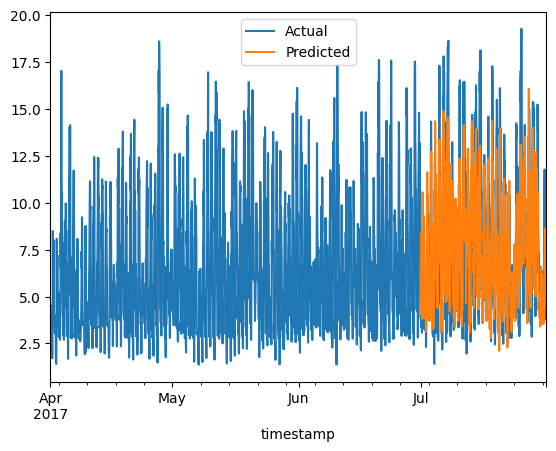

In [60]:
predicted_vs_actual_plus_training.plot()

In [61]:
# Calculate the absolute errors
errors = abs(predicted_vs_actual['Predicted'] - predicted_vs_actual['Actual'])
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / predicted_vs_actual['Actual']))

In [62]:
MAPE

np.float64(33.58833043899184)